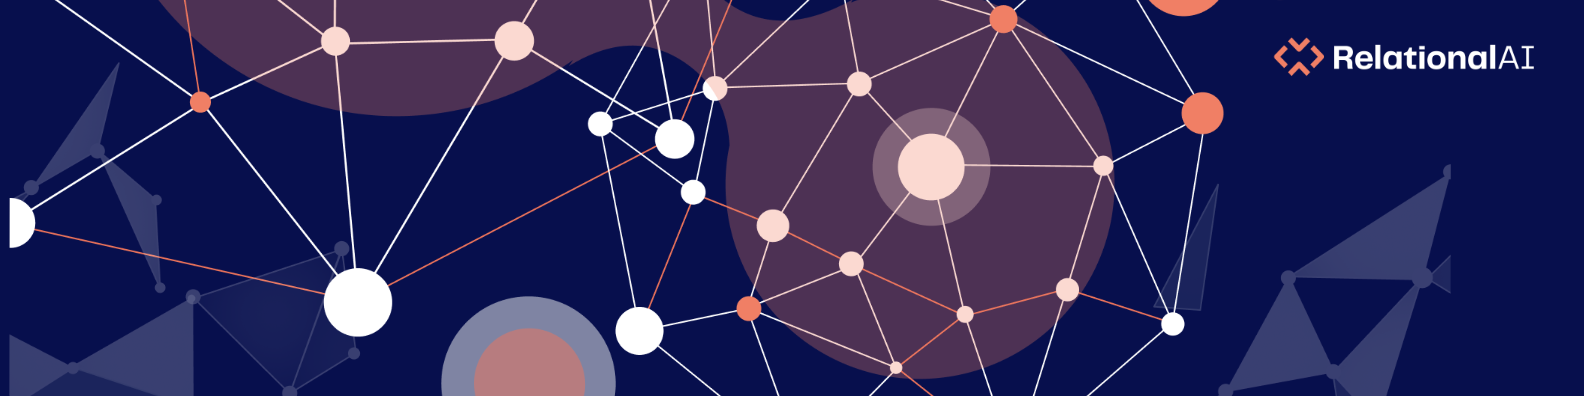

# Decision Tree
In this small demo we show how to traverse a decision tree based on some input parameters. We will model a small graph, which given a set of nodes and conditional paths between them will find a path to take and a final answer according to parameter values. 

As an example, we will try to create a small first aid guide, telling what action one can take to help someone in various medical emergencies.

## Modeling Knowledge Graph Entities

We start by importing all the Python packages that we will need, including the `relationalai` package. We then define a model object called `decision_tree` together with a few types: `TreeNode`, `Path`, `Tree`, `Rule`, `Answer` and `InputParameter`.

> **Note**. Models represent collections of objects. Objects, like Python objects, have types and properties, which we define using `model.Type()` method.


In [1]:
import os

def install_packages():
    os.system("pip install relationalai")

install_packages()

In [2]:
import relationalai as rai
from relationalai.std import alias
from relationalai.std.graphs import Graph

model = rai.Model("decision_tree")

TreeNode = model.Type("TreeNode")
Path = model.Type("Path")
Tree = model.Type("Tree") 
Rule = model.Type("Rule")
Answer = model.Type("Answer")

InputParameter = model.Type("InputParameter")

### Defining and importing input data

Next we define our data, as a set of dictionaries:
 * three dictionaries with node `id` to `label` mapping for a tree (root), rules and answers (leaves)
 * one dictionary with conditional expressions for rules
 * one for paths - mapping of `from_id` and `to_id` pair to a value which *from* node conditional expression needs to evaluate to in order for this path to be taken

In [3]:
trees =  {1: "First Aid Guide: What should you do in a medical emergency?",}
rules =  {2: "Person conscious?",
          3: "Person has severe bleeding?",
          4: "Person's body temperature too high?",
          5: "Person's body temperature too low?",
          6: "Person breathing?"}
answers= {7: "Apply pressure to the wound and call emergency services.",
          8: "Cool the person down and call emergency services.",
          9: "Warm the person and call emergency services.",
          10: "Continue to monitor the person and provide reassurance until help arrives.",
          11: "Place them in the recovery position and call emergency services.",
          12: "Begin chest compressions and rescue breaths. Call emergency services."}

rules_expressions = {2: (["is_conscious"], lambda p: p == "yes"),
                     3: (["has_severe_bleeding"], lambda p: p == "yes"),
                     4: (["body_temperature"], lambda p: p >= 38.2),
                     5: (["body_temperature"], lambda p: p <= 35.5),
                     6: (["is_breathing"], lambda p: p == "yes")}
rule_case_labels = {True: 'yes', False: 'no', None: ''}
# (from_id, to_id): condition
paths = {(1, 2): None, (2, 3) : True, (2, 6): False, (3, 7): True, (3, 4) : False, (4, 8): True, (4, 5): False, (5, 9): True, (5, 10): False, (6, 11): True, (6, 12): False}

Now we can create our input nodes from `trees`, `rules` and `answers` that we defined, setting `id` and `label` properties, as well as corresponding types (`Tree`, `Rule` and `Answer`).

> **Note**. We are using `model.rule()` context manager to populate our model types with instances. In this case, when we call `TreeNode.add()` method we create a new instance and provide its key property `id`. Then we use that instance to call `set()` method and assign additional `label` property, as well as to assign extra sub-type, i.e. nodes created from `trees` dictionary get `Tree` sub-type.


In [4]:
def create_input_nodes(dict, SubType):
    for id, label in dict.items():
        with model.rule():
            TreeNode.add(id = id).set(label = label).set(SubType)

create_input_nodes(trees, Tree)
create_input_nodes(rules, Rule)
create_input_nodes(answers, Answer)

Let's take a look at the nodes we just created. 

> **Note**. We are using `model.query()` context manager to query from our model. In this case all instances of `TreeNode` type are retrieved and then their properties `id` and `label` are added to the result of the query.


In [5]:
with model.query() as select:
    n = TreeNode()
    response = select(n.id, n.label)

response

Similarly, let's create paths between our nodes, saving also corresponding `condition` values as path properties.

> **Note**. Notice how we are passing extra `dynamic=True` parameter to `model.query()` call in this case. This allows us to build rule which depends on `condition` variable, which can be `None` - in this case we are not going to set it.

In [6]:
for (from_id, to_id), condition in paths.items():
    with model.rule(dynamic = True):
        p = Path.add(from_ = TreeNode(id = from_id), to_ = TreeNode(id = to_id)).set(label = rule_case_labels[condition])
        if condition is not None: p.set(condition = condition)

Let's now also query the `Paths` that we have created.

In [7]:
with model.query() as select:
    p = Path()
    response = select(p.from_.id, p.to_.id, alias(p.from_.label, 'from'), alias(p.label, 'path label'), alias(p.to_.label, 'to'))

response.results[['from', 'path label', 'to']]

from path label  \
0   First Aid Guide: What should you do in a medic...              
1                                   Person conscious?        yes   
2                                   Person conscious?         no   
3                         Person has severe bleeding?         no   
4                         Person has severe bleeding?        yes   
5                 Person's body temperature too high?         no   
6                 Person's body temperature too high?        yes   
7                  Person's body temperature too low?        yes   
8                  Person's body temperature too low?         no   
9                                   Person breathing?        yes   
10                                  Person breathing?         no   

                                                   to  
0                                   Person conscious?  
1                         Person has severe bleeding?  
2                                   Person breathing?  
3                 Person's body temperature too high?  
4   Apply pressure to the wound and call emergency...  
5                  Person's body temperature too low?  
6   Cool the person down and call emergency services.  
7        Warm the person and call emergency services.  
8   Continue to monitor the person and provide rea...  
9   Place them in the recovery position and call e...  
10  Begin chest compressions and rescue breaths. C...

### Visualizing the input data

Let's also create a `Graph` and visualize our input data. Here we are showing rules in yellow and the possible answers in red.

> **Note**. We are using `Graph(model)`  method to create a graph, where we then add our `TreeNode`s using `extend` method. We are also using `model.rule()` to add edges, in a same way as we did for other types in our model.


In [8]:
graph = Graph(model)
Node, Edge = graph.Node, graph.Edge

Node.extend(TreeNode, label = TreeNode.label)
Node.extend(Rule, color = '#EDB551', shape = 'rectangle')
Node.extend(Answer, color = '#F07F65', shape = 'hexagon')
Node.extend(Tree, color = '#3BACA3')

with model.rule():
    p = Path()
    Edge.add(p.from_, p.to_, label = p.label, color = '#3BACA3')

graph.visualize(three = False, show_edge_label = True, node_label_size_factor = 1.5, edge_label_size_factor = 1.5,
                layout_algorithm_active = False, layout_algorithm = "forceAtlas2Based", avoid_overlap = 1.0,
                style = { "node": { "size": 50 }, "edge": { "size": 2 } }
).display(inline = True)

### Extending the model and adding business logic

Now we want to add more rules to our model, which would allow traverse our decision tree depending on input parameters.
Let's add a rule using our input conditional expressions to assign `condition_value` properties to `Rule` nodes, depending on the corresponding `InputParameter` values.

In [9]:
for id, (expression_params, expression_func) in rules_expressions.items():
    with model.rule(dynamic = True):
        r = Rule(id = id)
        with expression_func(*[InputParameter(name = p).value for p in expression_params]):
            r.set(condition_value = True)

Finally, let's add a rule that would set `ActivePath` type, meaning the path currently taken according to parameter values passed, for all `Path`s that have their `condition` matching the `condition_value` of the `from_` node, as well as for the paths that don't have any `condition` set at all.

> **Note**. Notice that because in the previous rule we only set `condition_value` when it is *True*, here we are using `or_()` method allowing to pass a default value if property is not set.
Also, when we want to do something else, when a property is not set, we can use `model.not_found()` context manager, as we did in the second rule here.

In [10]:
ActivePath = model.Type("ActivePath")

with model.rule():
    p = Path()
    p.from_.condition_value.or_(False) == p.condition
    ActivePath(to_ = p.from_)
    p.set(ActivePath)

with model.rule():
    p = Path()
    with model.not_found(): p.condition
    p.set(ActivePath)

## Finding the right path based on the inputs

Now let's get the answer to our question.
Our tree needs 4 input parameters according to our input data:
- whether the person is conscious
- whether the person has severe bleeding
- person's body temperature
- whether the person is breathing.

We assign values to them.

In [11]:
tree = "First Aid Guide: What should you do in a medical emergency?"
parameters = {"is_conscious": "yes",
              "has_severe_bleeding": "no",
              "body_temperature": 39.0,
              "is_breathing": "yes"}

Next, we want to figure out which of the possible paths will be traversed given these input parameters. We do this by adding rules to populate our `InputParameter` type with instances of our parameters, having `name` and `value` properties.

In [12]:
with model.rule(dynamic = True):
    for name, value in parameters.items():
        InputParameter.add(name = name).set(value = value)

## Visualizing the results
Now let's look at the path we are taking and our final answer. We are now highlighting with colors only relevant nodes and edges.

In [13]:
with model.rule():
    p = ActivePath()
    Edge(p.from_, p.to_).set(focus = 'active')
    Node(p.from_).set(focus = 'active')
    Node(p.to_).set(focus = 'active')

graph.visualize(three = False, show_edge_label = True, node_label_size_factor = 1.5, edge_label_size_factor = 1.5,
                layout_algorithm_active = False, layout_algorithm = "forceAtlas2Based", avoid_overlap = 1.0,
                style = {
                    "node": {
                    "color": lambda n : n['color'] if n.get('focus') else '#92979C',
                    "size": lambda n: 50 if n.get('focus') else 30
                    },
                    "edge": {
                        "color": lambda e : '#F07F65' if e.get('focus') else '#92979C',
                        "size": lambda e: 3 if e.get('focus') else 1
                    }
                }
).display(inline = True)

> **Tip**. Our answer says in this case we need to cool the person down and call emergency services.